In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools


In [2]:
def loaddata(path):
    f = open(path, "r")
    txt = f.readlines()
    data = []
    for line in txt:
        i, x, y = line.split()
        data.append([float(x), float(y)])
    data = np.array(data)

    return data

In [7]:
class SOM:
    def __init__(self, X, numOfclasses, learning_rate, radius, decay):
        self.X = X
        self.numOfclasses = numOfclasses
        self.weights = self.init_weights(self.X.shape[1], numOfclasses)
        self.learning_rate = learning_rate
        self.radius = radius
        self.decay = decay
        self.min_max = [X.min(0).min(0), X.max(0).max(0)]
        
    def normilization(self, x):
        minn = self.min_max[0]
        maxx = self.min_max[1]
        return ((x - minn) / (maxx - minn))

    def denormization(self,x):
        minn = self.min_max[0]
        maxx = self.min_max[1]
        return (x *(maxx - minn) + minn)

    def init_weights(self, mdim, nclass):
        w = np.random.rand(nclass, mdim)
        return w

    def get_neighbor(self,x):
        winner = np.argmin(np.sum((self.weights - x)**2, axis=1))
        return winner

    def update_weights(self,winner,x):
        self.weights[winner] = self.weights[winner] + self.learning_rate * (x - self.weights[winner])
        
    def train(self,epochs=100):
        self.X = self.normilization(self.X)
        for epoch in range(epochs):
            for x in self.X:
                winner = self.get_neighbor(x)
                self.update_weights(winner,x)
            self.learning_rate *= self.decay
            self.radius *= self.decay

    def predict(self, x):
        winner = self.get_neighbor(x)
        return(winner)

    def plot(self):
        plot = [[0 for i in range(int(self.min_max[0])+1,int(self.min_max[1]+1))] for j in range(int(self.min_max[0])+1,int(self.min_max[1]+1))]
        for i in range(len(plot)):
            for j in range(len(plot[0])):
                point = np.array([i,j])
                point = self.normilization(point)
                plot[i][j] = self.predict(point) * (255/self.numOfclasses)
        for x in self.X:
            x = self.denormization(x)
            plt.scatter(x[0], x[1], color='black')
        plt.imshow(plot, cmap='jet')

        return plot

class TSP:
    def __init__(self,X, som):
        self.X = X
        self.som = som
        self.numOfclasses = som.numOfclasses

    def calculate_cost(self,x):
        cost = 0
        for i in range(len(x)):
            if i != len(x)-1:
                cost += math.sqrt(np.sum((x[i] - x[i+1])**2))
            else:
                cost += math.sqrt(np.sum((x[0] - x[i])**2))
        return cost

    def get_all_per(self,c):
        paths = list(itertools.permutations(c))
        return paths

    def seperate_data(self):
        self.classes = [[] for i in range(self.numOfclasses)]
        for x in self.X:
            self.classes[self.som.predict(x)].append(x)

    def plot(self,best_paths):
        for x in self.X:
            x = self.som.denormization(x)
            plt.scatter(x[0], x[1], color='black')

        for j,path in enumerate(best_paths):
            for i in range(len(path)):
                if i != self.deleted_lines[j]:
                    if i != len(path)-1:
                        plt.plot([self.som.denormization(path[i][0]), self.som.denormization(path[i+1][0])], [self.som.denormization(path[i][1]), self.som.denormization(path[i+1][1])], color='red')
                    else:
                        plt.plot([self.som.denormization(path[i][0]), self.som.denormization(path[0][0])], [self.som.denormization(path[i][1]), self.som.denormization(path[0][1])], color='red')
        
        for line in self.lines[:]:
            plt.plot([self.som.denormization(line[0][0]), self.som.denormization(line[1][0])], [self.som.denormization(line[0][1]), self.som.denormization(line[1][1])], color='blue')
        
        plt.show()

    def find_free_nodes(self,paths_permitation):
        deleted_lines = list()
        for path in paths_permitation:
            if len(path) > 2:
                lines_cost = list()
                for i in range(len(path)):
                    if i != len(path)-1:
                        lines_cost.append(math.sqrt(np.sum((path[i] - path[i+1])**2)))
                    else:
                        lines_cost.append(math.sqrt(np.sum((path[i] - path[0])**2)))
                max_cost = np.argmax(lines_cost)
                deleted_lines.append(max_cost)
            else:
                deleted_lines.append(None)
        
        free_nodes = list()
        for i,path in enumerate(paths_permitation):
            if len(path) > 2:
                ii = deleted_lines[i]
                free_nodes.append([path[ii],path[(ii+1)%len(path)]])
            else:
                free_nodes.append(path)
        self.deleted_lines = deleted_lines
        return free_nodes

    def change_pairs(self):
        for i in range(0,len(self.lines),1):
            if i != len(self.lines)-1:
                x1 = self.lines[i][0]
                y1 = self.lines[i][1]
                x2 = self.lines[i+1][0]
                y2 = self.lines[i+1][1]

                old_cost = math.sqrt(np.sum((x1 - y1 )**2)) + math.sqrt(np.sum((x2 - y2)**2))
                new_cost = math.sqrt(np.sum((x1 - y2)**2)) + math.sqrt(np.sum((x2 - y1)**2))
                if new_cost < old_cost:
                    self.lines[i] = [x1,x2]
                    self.lines[i+1] = [y1,y2]
            else:
                x1 = self.lines[i][0]
                y1 = self.lines[i][1]
                x2 = self.lines[0][0]
                y2 = self.lines[0][1]

                old_cost = math.sqrt(np.sum((x1 - y1 )**2)) + math.sqrt(np.sum((x2 - y2)**2))
                new_cost = math.sqrt(np.sum((x1 - y2)**2)) + math.sqrt(np.sum((x2 - y1)**2))
                if new_cost < old_cost:
                    self.lines[i] = [x1,x2]
                    self.lines[0] = [y1,y2]
            
    def find_best_path(self,free_nodes):
        self.lines = list()
        s = 1
        end_point = [s,0]
        if len(free_nodes[s])>1:
            start_point = [s,1]
        else:
            start_point = [s,0]

        mask = [1 for i in range(len(free_nodes))]
        mask[s] = 0


        while 1 in mask:
            min_dist = np.inf
            min_node = None
            for i in range(len(free_nodes)):
                if mask[i] == 1:
                    for j in range(len(free_nodes[i])):
                        dist = math.sqrt(np.sum((free_nodes[i][j] - start_point)**2))
                        if dist < min_dist:
                            min_dist = dist
                            min_node = [i,j]
            if min_node != None:
                self.lines.append([free_nodes[start_point[0]][start_point[1]],free_nodes[min_node[0]][min_node[1]]])
                start_point = [min_node[0],(min_node[1]+1)%len(free_nodes[min_node[0]])]
            mask[start_point[0]] = 0
        self.lines.append([free_nodes[min_node[0]][(min_node[1]+1)%len(free_nodes[min_node[0]])],free_nodes[end_point[0]][end_point[1]]])
        self.change_pairs()

    def train(self):
        self.seperate_data()
        best_paths = list()
        for c in self.classes:
            if len(c) < 1:
                continue
            paths = self.get_all_per(c)
            costs = []
            i = 0
            for path in paths:
                i+=1
                costs.append(self.calculate_cost(path))
            costs = np.array(costs)
            best_paths.append(paths[np.argmin(costs)])

        free_nodes = self.find_free_nodes(best_paths)
        self.find_best_path(free_nodes)
        
        self.plot(best_paths)

In [26]:
som = SOM(loaddata("1.tsp"),
          numOfclasses = 9, 
          learning_rate = 0.4, 
          radius = 1, 
          decay = 0.98)

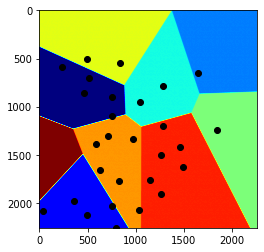

In [27]:
som.train(1000)
plot = som.plot()

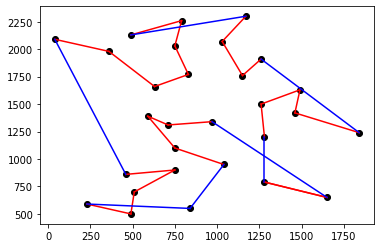

In [192]:
TSPSOM = TSP(som.X, som)
TSPSOM.train()

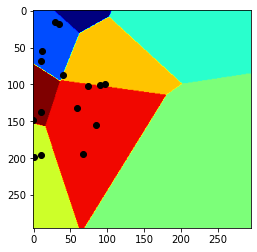

In [5]:
som = SOM(loaddata("2.tsp"),
          numOfclasses = 11, 
          learning_rate = 0.4, 
          radius = 1, 
          decay = 0.98)
som.train(2000)
plot = som.plot()

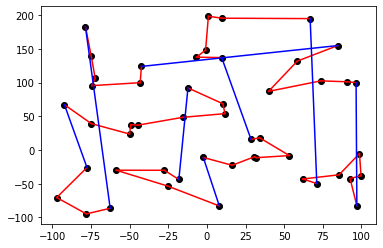

In [6]:
TSPSOM = TSP(som.X, som)
TSPSOM.train()